<a href="https://colab.research.google.com/github/devansurf/CoralSight-Binary/blob/main/CoralSight_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CoralSight Binary
Computer vision model to differentiate between bleached and non-bleached corals

In [101]:
#Fetch dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
#Libaries
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
#import optuna #tuner
import re
import random
import seaborn as sns
from collections import Counter
from itertools import chain

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torch.nn import Module, Conv2d, ConvTranspose2d, Dropout, BatchNorm2d
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import random_split


from PIL import Image

from collections import Counter
from tqdm import tqdm
from IPython.display import display, Math, Latex
from sklearn.utils import resample
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split

In [103]:
#directories
bleached_corals_dir = '/content/drive/MyDrive/MachineLearning/coral-dataset/bleached_corals'
healthy_corals_dir = '/content/drive/MyDrive/MachineLearning/coral-dataset/healthy_corals'

In [104]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [105]:
def to_numpy(x):

    return x.detach().cpu().numpy()

In [106]:
#Configuration
class Config:
    learning_rate = 0.00005
    num_epochs = 10
    batch_size = 32
    dropout = 0.5

    img_dimensions = (128, 128)

    training_proportion = 0.7
    validation_proportion = 0.2

In [107]:
class CoralDataset(Dataset):
    def __init__(self, bleached_dir, healthy_dir, transform=None):
        self.bleached_images = [os.path.join(bleached_dir, img) for img in os.listdir(bleached_dir)]
        self.healthy_images = [os.path.join(healthy_dir, img) for img in os.listdir(healthy_dir)]

        # Combine and label images: 0 for bleached, 1 for healthy
        self.all_images = self.bleached_images + self.healthy_images
        self.labels = [0] * len(self.bleached_images) + [1] * len(self.healthy_images)

        self.transform = transform

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, index):
        img_path = self.all_images[index]
        label = self.labels[index]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [108]:
class CoralCNN(nn.Module):
    def __init__(self, dropout=0.5):
        super(CoralCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Adjust the size (this is for 128x128)
        self.fc2 = nn.Linear(512, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)  # Adjust the size (this is for 128x128)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

In [109]:
def train_model(learning_rate, num_epochs, dropout, train_loader, valid_loader):
    model = CoralCNN(dropout=dropout)
    if torch.cuda.is_available():
        model = model.cuda()

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

    acc_hist_train = []
    acc_hist_val = []

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader):
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

            predicted = torch.round(outputs.data.squeeze())  # Round to 0 or 1
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train
        acc_hist_train.append(train_accuracy)
        train_losses.append(train_loss)

        model.eval()
        valid_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                if torch.cuda.is_available():
                    images, labels = images.cuda(), labels.cuda()

                outputs = model(images)
                loss = criterion(outputs.squeeze(), labels.float())

                valid_loss += loss.item() * images.size(0)

                predicted = torch.round(outputs.data.squeeze())
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_accuracy = correct_val / total_val
        acc_hist_val.append(valid_accuracy)
        val_losses.append(valid_loss)

        print(f"Epoch: {epoch}")
        print(f"Train Acc: {train_accuracy:.3f}")
        print(f"Val Acc: {valid_accuracy:.3f}")
        print(f"Train Loss: {train_loss:.3f}")
        print(f"Val Loss: {valid_loss:.3f}")
        print("---------------------------------------------")

    #model = CoralCNN(dropout)
    model.eval()
    return model, acc_hist_train, acc_hist_val, train_losses, val_losses

**Create the Dataset with the specified transform (augmentation)** 😀

In [110]:
transform = transforms.Compose([
    transforms.Resize(Config.img_dimensions),
    transforms.ToTensor()
])

dataset = CoralDataset(bleached_corals_dir, healthy_corals_dir, transform=transform)

#calculate lengths
total_size = len(dataset)
train_size = int(total_size * Config.training_proportion)
valid_size = int(total_size * Config.validation_proportion)
test_size = total_size - train_size - valid_size

# Split the dataset
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

#creating data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=Config.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False)


**Display some images and labels for reference**

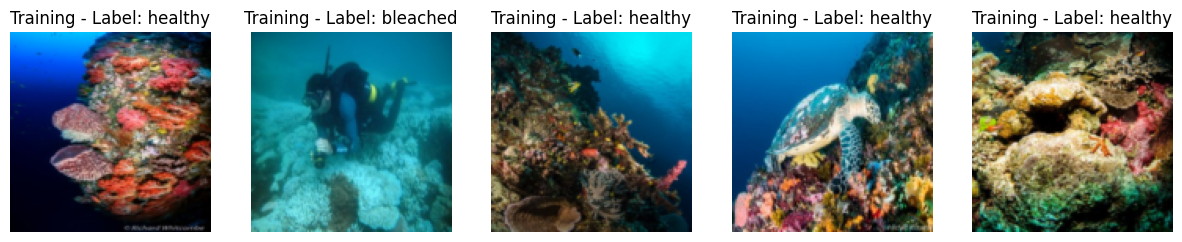

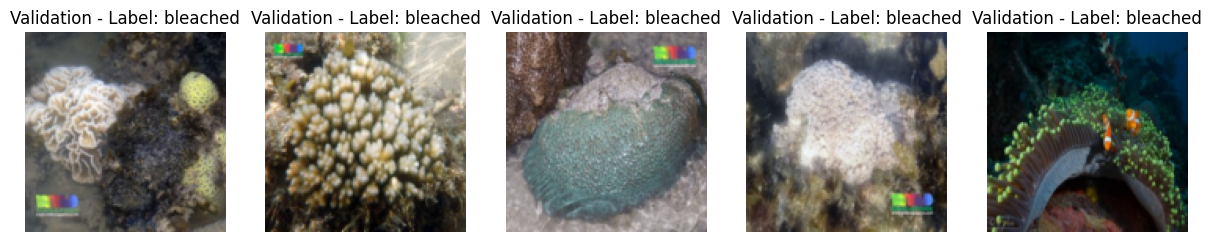

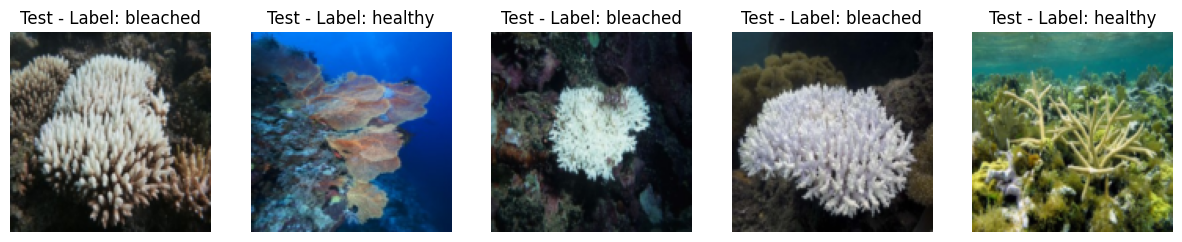

In [111]:
def show_random_images(subset, subset_name, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        # Randomly select an index
        idx = random.randint(0, len(subset) - 1)

        # Get the image and label
        image, label= subset[idx]
        label = 'bleached' if label == 0 else 'healthy'
        # Convert the tensor image to a NumPy array for visualization
        image_np = image.permute(1, 2, 0).numpy()

        # Subplot for each image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image_np)
        plt.title(f'{subset_name} - Label: {label}')
        plt.axis('off')

    plt.show()

show_random_images(train_dataset, 'Training', num_images=5)
show_random_images(valid_dataset, 'Validation', num_images=5)
show_random_images(test_dataset, 'Test', num_images=5)

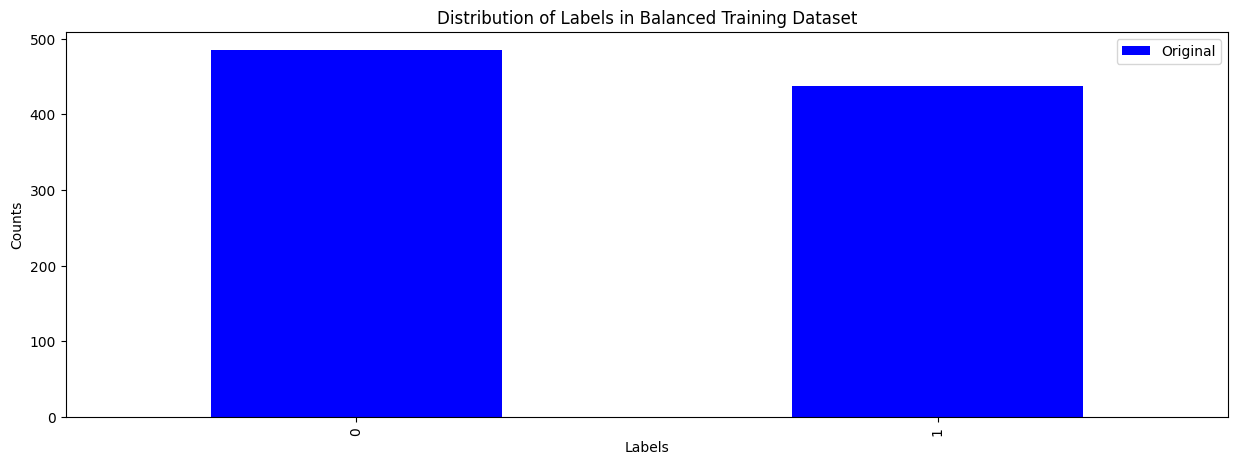

In [112]:
counts = {}
for _, label in dataset:
    if label in counts:
        counts[label] += 1
    else:
        counts[label] = 1

counts_series = pd.Series(counts)

# Plot the label counts
plt.figure(figsize=(15, 5))
# Plot original counts
counts_series.plot(kind='bar', color='blue', label='Original')

plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Distribution of Labels in Balanced Training Dataset')
plt.legend()
plt.show()

**Train the model !!!!**

In [113]:
model, acc_hist_train, acc_hist_val, train_losses, val_losses = train_model(Config.learning_rate, Config.num_epochs, Config.dropout, train_loader, valid_loader)

100%|██████████| 21/21 [00:02<00:00,  8.43it/s]


Epoch: 0
Train Acc: 0.553
Val Acc: 0.690
Train Loss: 0.687
Val Loss: 0.672
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  7.08it/s]


Epoch: 1
Train Acc: 0.605
Val Acc: 0.707
Train Loss: 0.662
Val Loss: 0.632
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  8.34it/s]


Epoch: 2
Train Acc: 0.689
Val Acc: 0.717
Train Loss: 0.620
Val Loss: 0.592
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  8.42it/s]


Epoch: 3
Train Acc: 0.697
Val Acc: 0.734
Train Loss: 0.584
Val Loss: 0.568
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  8.53it/s]


Epoch: 4
Train Acc: 0.714
Val Acc: 0.728
Train Loss: 0.560
Val Loss: 0.558
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  7.57it/s]


Epoch: 5
Train Acc: 0.715
Val Acc: 0.707
Train Loss: 0.559
Val Loss: 0.554
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  7.60it/s]


Epoch: 6
Train Acc: 0.706
Val Acc: 0.717
Train Loss: 0.558
Val Loss: 0.552
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  8.46it/s]


Epoch: 7
Train Acc: 0.721
Val Acc: 0.712
Train Loss: 0.543
Val Loss: 0.551
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  8.46it/s]


Epoch: 8
Train Acc: 0.717
Val Acc: 0.723
Train Loss: 0.533
Val Loss: 0.545
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  7.13it/s]


Epoch: 9
Train Acc: 0.724
Val Acc: 0.717
Train Loss: 0.529
Val Loss: 0.543
---------------------------------------------


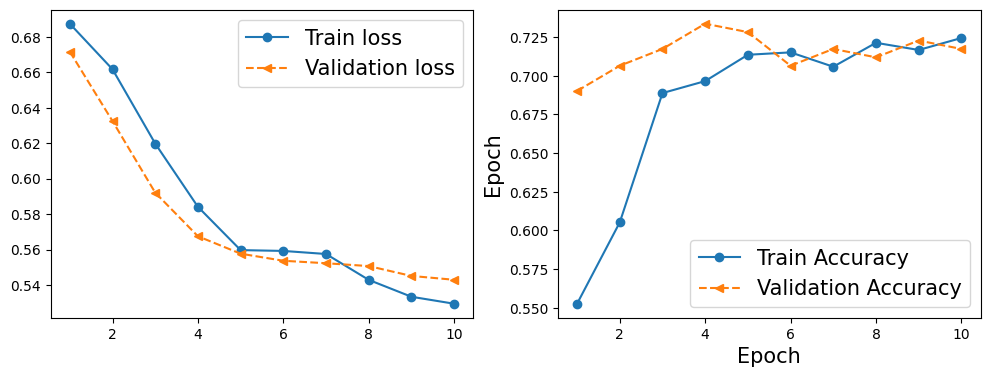

In [114]:
#Plot graphs
x_axis = np.arange(Config.num_epochs) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)

ax.plot(x_axis, train_losses, '-o', label = 'Train loss')
ax.plot(x_axis, val_losses, '--<', label = 'Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_axis, acc_hist_train, '-o', label='Train Accuracy')
ax.plot(x_axis, acc_hist_val, '--<', label='Validation Accuracy')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Epoch', size=15)
plt.show()

In [115]:
#Final results
total_correct = 0
total_samples = 0
actual_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()

        pred = model(x)  # predict, this should output the probability of being class '1' (e.g., 'healthy')
        predictions = torch.round(pred.squeeze()) # Threshold at 0.5; if pred >= 0.5, predictions = 1

        total_correct += (predictions == y).sum().item()
        total_samples += y.size(0)

        actual_labels.extend(to_numpy(y))
        predicted_labels.extend(to_numpy(predictions))

accuracy_test = total_correct / total_samples

print(f'test accuracy: {accuracy_test}')
print("NOTE: Test Accuracy above is provided for reference only. It can be a misleading statistic for imbalanced data.")
F1_score = f1_score(actual_labels, predicted_labels, average='macro')
print(f'F1_score: {F1_score}')

test accuracy: 0.7526881720430108
NOTE: Test Accuracy above is provided for reference only. It can be a misleading statistic for imbalanced data.
F1_score: 0.7522298158230047


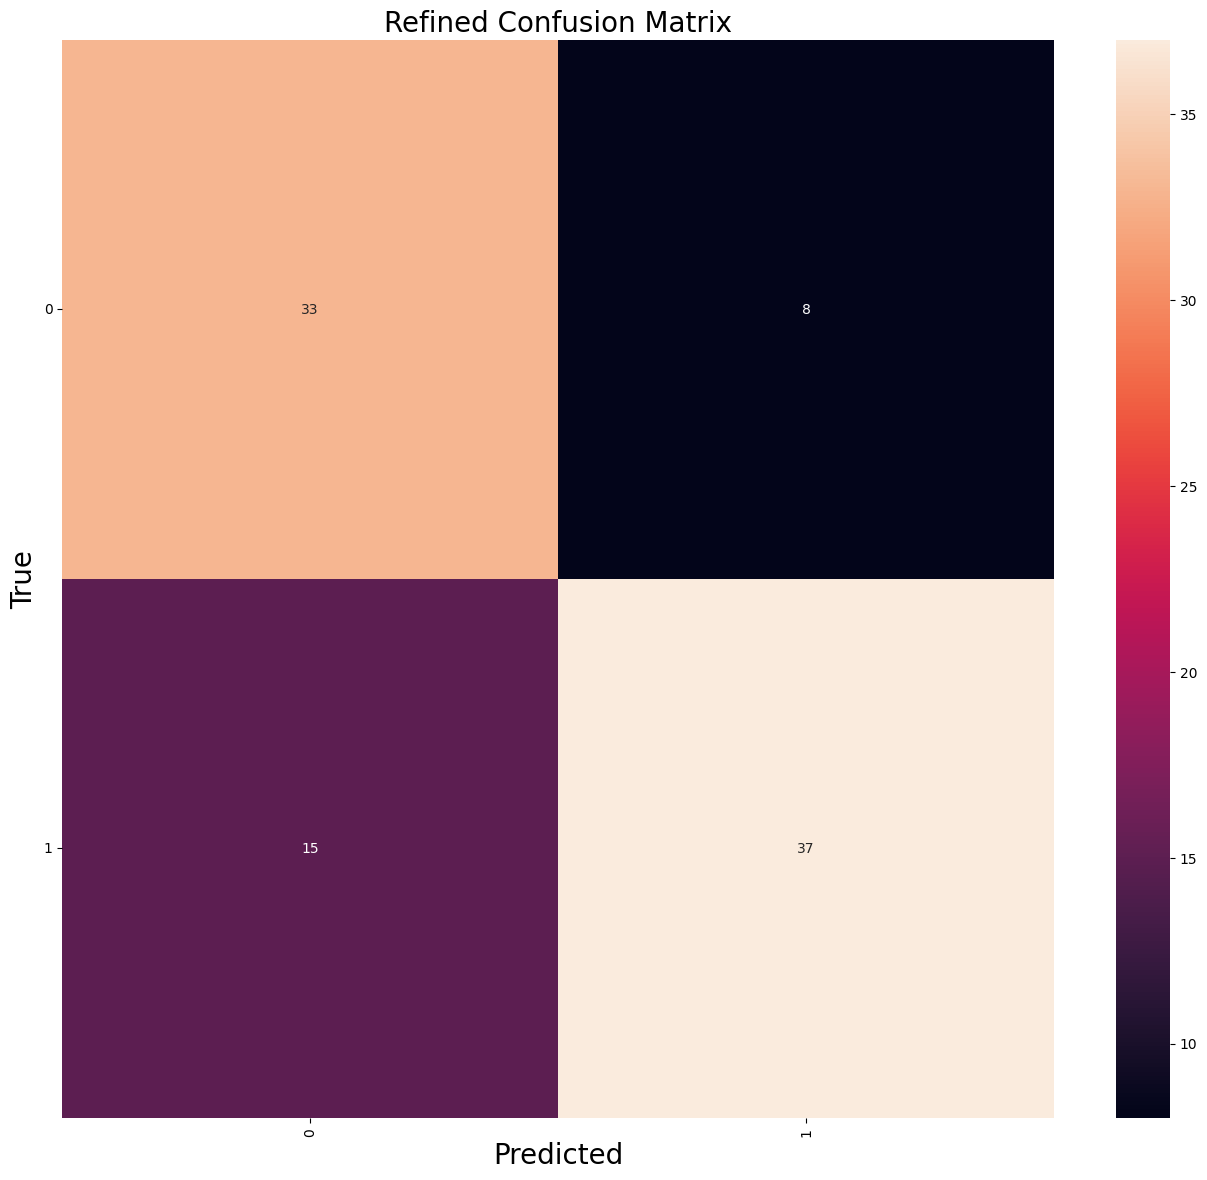

f1_score: 0.7522298158230047


In [116]:
#Confusion matrix:
cm = confusion_matrix(actual_labels, predicted_labels)

labels = list(set(dataset.labels))

fig = plt.figure(figsize=(16, 14))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt="g")
ax.set_xlabel("Predicted", fontsize=20)
ax.xaxis.set_label_position("bottom")
plt.xticks(rotation=90)
ax.xaxis.tick_bottom()

ax.set_ylabel("True", fontsize=20)
plt.yticks(rotation=0)

plt.title("Refined Confusion Matrix", fontsize=20)

plt.show()

F1_score = f1_score(actual_labels, predicted_labels, average='macro')

print(f'f1_score: {F1_score}')